In [30]:
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import xgboost as xgb
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from xgboost import plot_tree
from sklearn.model_selection import cross_val_score

# read StudentPerformanceFactors
raw_data = pd.read_csv('StudentPerformanceFactors.csv')
print(raw_data.shape)

(6607, 20)


In [31]:
# remove rows with missing values

cols = raw_data.columns
categorical_cols = [
    'Parental_Involvement',
    'Access_to_Resources',
    'Extracurricular_Activities',
    'Motivation_Level',
    'Internet_Access',
    'Family_Income',
    'Teacher_Quality',
    'School_Type',
    'Peer_Influence',
    'Learning_Disabilities',
    'Parental_Education_Level',
    'Distance_from_Home',
    'Gender'
]

numerical_cols = [
    'Hours_Studied',
    'Attendance',
    'Sleep_Hours',
    'Previous_Scores',
    'Tutoring_Sessions',
    'Physical_Activity',
    'Exam_Score'
]

for col in categorical_cols:
  raw_data[col] = raw_data[col].replace('', np.nan)

raw_data.dropna(inplace=True)
print(raw_data.shape)

(6378, 20)


In [32]:
df = raw_data.copy()
df_encoded = pd.get_dummies(df, columns=categorical_cols)
df_encoded.head()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score,Parental_Involvement_High,Parental_Involvement_Low,Parental_Involvement_Medium,...,Learning_Disabilities_No,Learning_Disabilities_Yes,Parental_Education_Level_College,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Distance_from_Home_Far,Distance_from_Home_Moderate,Distance_from_Home_Near,Gender_Female,Gender_Male
0,23,84,7,73,0,3,67,False,True,False,...,True,False,False,True,False,False,False,True,False,True
1,19,64,8,59,2,4,61,False,True,False,...,True,False,True,False,False,False,True,False,True,False
2,24,98,7,91,2,4,74,False,False,True,...,True,False,False,False,True,False,False,True,False,True
3,29,89,8,98,1,4,71,False,True,False,...,True,False,False,True,False,False,True,False,False,True
4,19,92,6,65,3,4,70,False,False,True,...,True,False,True,False,False,False,False,True,True,False


In [50]:
#shuffle the data's indices in the data set
Splitter = GroupShuffleSplit(test_size=.10, n_splits=1, random_state = 7)
#seperate indices into train and split
train_indices, Cross_Validation_indices = next(Splitter.split(df, groups=df['Exam_Score']))
#seperate x values and y values by the indices for the corss validation set
x_Cross_Validation = df_encoded.iloc[Cross_Validation_indices]
y_Cross_Validation = df_encoded.iloc[Cross_Validation_indices]['Exam_Score']
x_Cross_Validation = x_Cross_Validation.drop('Exam_Score', axis=1)
x_Cross_Validation.shape, y_Cross_Validation.shape

((936, 40), (936,))

In [54]:
#standardization and Dimension Reduction
features = df_encoded.drop('Exam_Score', axis=1)
target = df_encoded['Exam_Score']
x_scaled = StandardScaler().fit_transform(features)
x_cross_validation_scaled = StandardScaler().fit_transform(x_Cross_Validation)
pca = PCA(n_components=.95)
x_pca = pca.fit_transform(x_scaled)
x_pca_cross_validation = pca.transform(x_cross_validation_scaled)

In [35]:
#seperate the train and test indices into x and y data sets for the non hierarchical set
x_train, x_test, y_train, y_test = train_test_split(df_encoded.iloc[train_indices], df_encoded.iloc[train_indices]['Exam_Score'], test_size=0.10, random_state=48)
x_train.shape, x_test.shape, y_train.shape, y_test.shape
x_train = x_train.drop('Exam_Score', axis=1)
x_test = x_test.drop('Exam_Score', axis=1)

In [36]:
#seperate the train and test indices into x and y data sets for the non hierarchical set but for the PCA features
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca[train_indices], target.iloc[train_indices], test_size=0.10, random_state=48)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4897, 40), (545, 40), (4897,), (545,))

MSE: 6.13
R2: 0.62


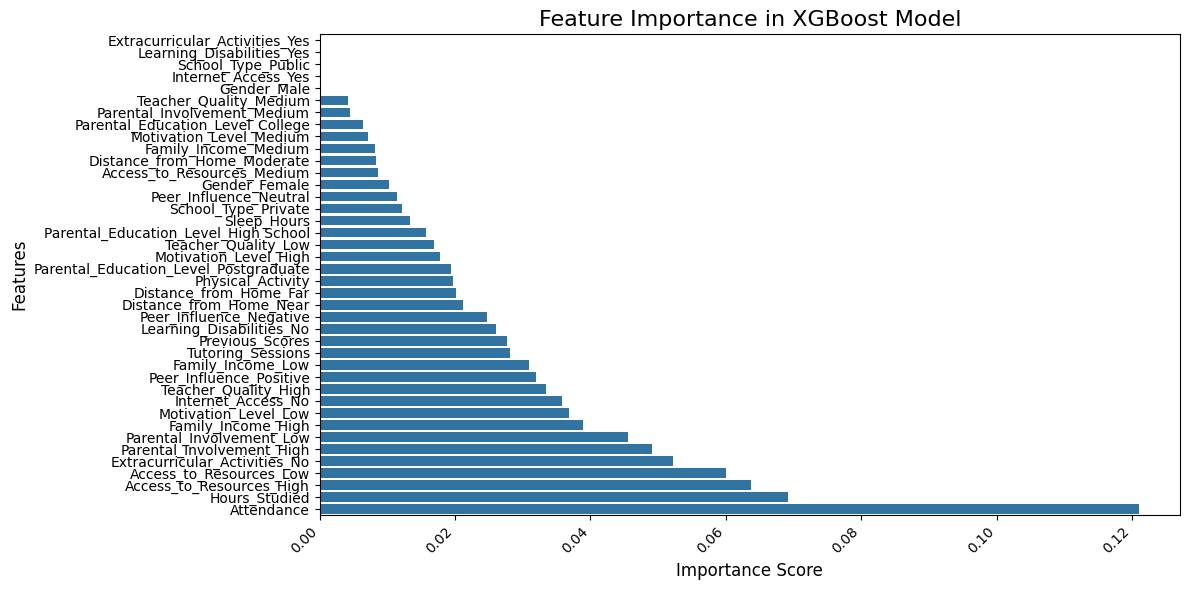

In [72]:
#do some xgboosting without dimensional reduction
x_xgboost = x_train
y_xgboost = y_train

model = xgb.XGBRegressor(objective="reg:squarederror", random_state=37)
model.fit(x_xgboost, y_xgboost)
predictions = model.predict(x_test)
mse = mean_squared_error(y_test, predictions)
print("MSE: %.2f" % mse)
r2 = r2_score(y_test, predictions)
print("R2: %.2f" % r2)

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=x_train.columns[indices])
plt.title("Feature Importance in XGBoost Model", fontsize=16)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

MSE: 7.48
R2: 0.54


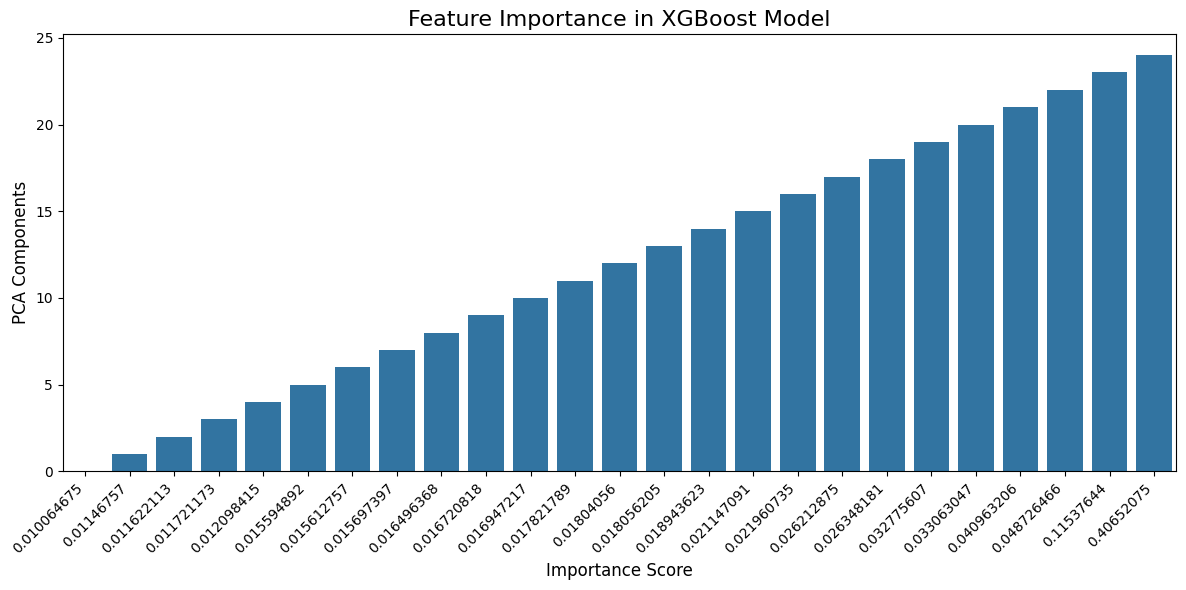

In [71]:
#do some xgboosting with dimensional reduction
x_xgboost = x_train_pca
y_xgboost = y_train_pca

model = xgb.XGBRegressor(objective="reg:squarederror", random_state=37)
model.fit(x_xgboost, y_xgboost)
predictions = model.predict(x_test_pca)
mse = mean_squared_error(y_test_pca, predictions)
print("MSE: %.2f" % mse)
r2 = r2_score(y_test_pca, predictions)
print("R2: %.2f" % r2)

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=range(x_train_pca.shape[1]))
plt.title("Feature Importance in XGBoost Model", fontsize=16)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("PCA Components", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

MSE: 6.47
R2: 0.60


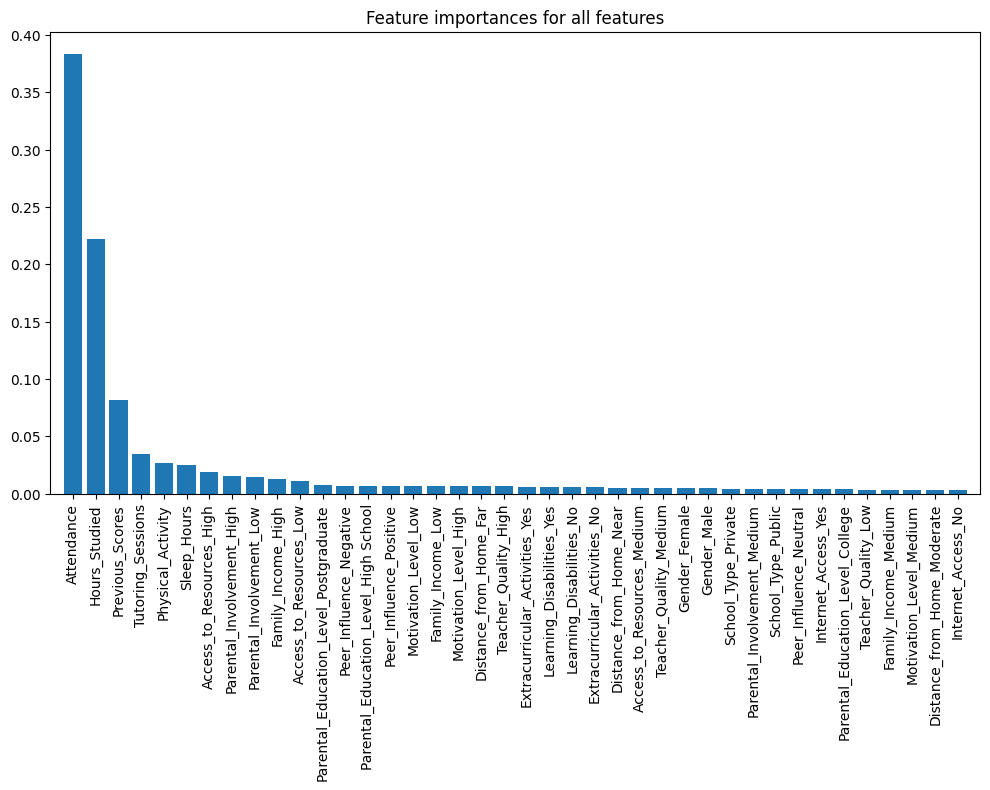

In [39]:
#random forest for encoded data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)
predictions = rf_model.predict(x_test)

mse = mean_squared_error(y_test, predictions)
print("MSE: %.2f" % mse)
r2 = r2_score(y_test, predictions)
print("R2: %.2f" % r2)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature importances for all features")
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation = 90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

MSE: 8.21
R2: 0.49


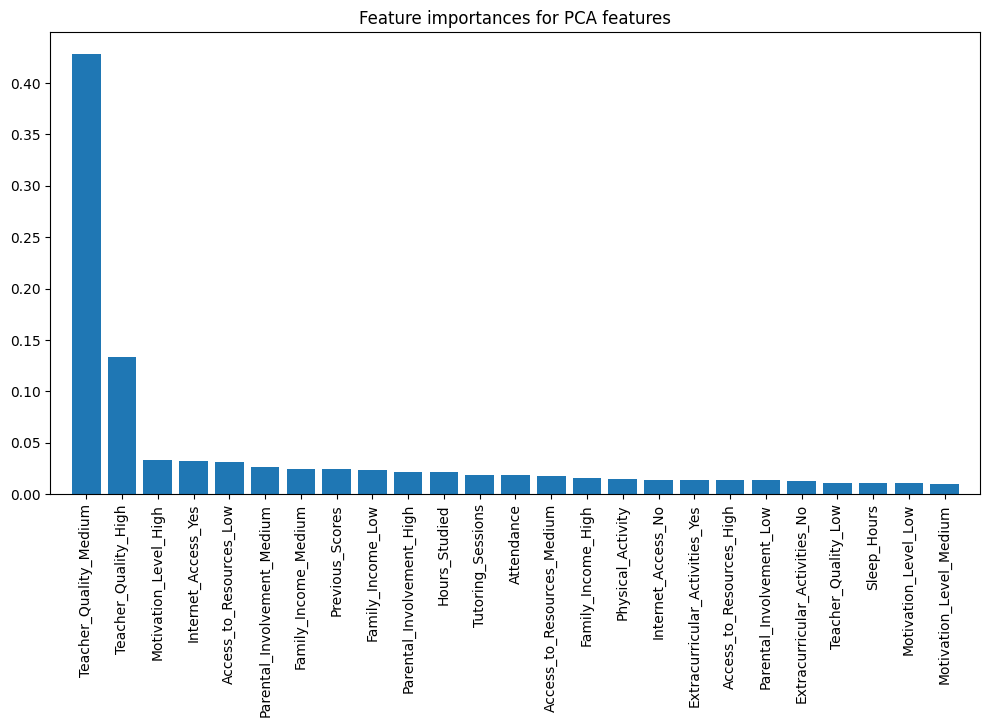

In [40]:
#random forest for encoded data with PCA
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train_pca, y_train_pca)
predictions = rf_model.predict(x_test_pca)

mse = mean_squared_error(y_test_pca, predictions)
print("MSE: %.2f" % mse)
r2 = r2_score(y_test_pca, predictions)
print("R2: %.2f" % r2)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature importances for PCA features")
plt.bar(range(x_train_pca.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train_pca.shape[1]), x_train.columns[indices], rotation = 90)
plt.xlim([-1, x_train_pca.shape[1]])
plt.show()

In [58]:
#Cross validation of XGBoost, Random Forest, and both with PCA as well in that order
scores_xgb = cross_val_score(model, x_Cross_Validation, y_Cross_Validation, cv=5, scoring='neg_mean_squared_error')
scores_xgb_r2 = cross_val_score(model, x_Cross_Validation, y_Cross_Validation, cv=5, scoring='r2')
print("MSE of Cross Validation XGB: " + str(-scores_xgb))
print("Mean of Cross Validation XGB MSEs: " + str(-scores_xgb.mean()))
print("R2 of Cross Validation XGB: " + str(scores_xgb_r2))
print("Mean of Cross Validation XGB R2s: " + str(scores_xgb_r2.mean()))

print()
print()

scores_rf = cross_val_score(rf_model, x_Cross_Validation, y_Cross_Validation, cv=5, scoring='neg_mean_squared_error')
scores_rf_r2 = cross_val_score(rf_model, x_Cross_Validation, y_Cross_Validation, cv=5, scoring='r2')
print("MSE of Cross Validation RF: " + str(-scores_rf))
print("Mean of Cross Validation of RF MSEs: " + str(-scores_rf.mean()))
print("R2 of Cross Validation RF: " + str(scores_rf_r2))
print("Mean of Cross Validation of RF R2s: " + str(scores_rf_r2.mean()))

print()
print()

scores_xgb_pca = cross_val_score(model, x_pca_cross_validation, y_Cross_Validation, cv=5, scoring='neg_mean_squared_error')
scores_xgb_r2_pca = cross_val_score(model, x_pca_cross_validation, y_Cross_Validation, cv=5, scoring='r2')
print("MSE of Cross Validation XGB PCA: " + str(-scores_xgb_pca))
print("Mean of Cross Validation XGB PCA MSEs: " + str(-scores_xgb_pca.mean()))
print("R2 of Cross Validation XGB PCA: " + str(scores_xgb_r2_pca))
print("Mean of Cross Validation XGB PCA R2s: " + str(scores_xgb_r2_pca.mean()))

print()
print()

scores_rf_pca = cross_val_score(rf_model, x_pca_cross_validation, y_Cross_Validation, cv=5, scoring='neg_mean_squared_error')
scores_rf_r2_pca = cross_val_score(rf_model, x_pca_cross_validation, y_Cross_Validation, cv=5, scoring='r2')
print("MSE of Cross Validation RF PCA: " + str(-scores_rf_pca))
print("Mean of Cross Validation RF PCA MSEs: " + str(-scores_rf_pca.mean()))
print("R2 of Cross Validation RF PCA: " + str(scores_rf_r2_pca))
print("Mean of Cross Validation RF PCA R2s: " + str(scores_rf_r2_pca.mean()))

MSE of Cross Validation XGB: [1.45144129 1.15203679 0.98761606 1.70577192 1.94187057]
Mean of Cross Validation XGB MSEs: 1.4477473258972169
R2 of Cross Validation XGB: [0.73325288 0.81336308 0.81625319 0.66435695 0.73370278]
Mean of Cross Validation XGB R2s: 0.7521857738494873


MSE of Cross Validation RF: [1.2019766  0.95620695 1.10690856 1.83333262 1.77472834]
Mean of Cross Validation of RF MSEs: 1.3746306132665835
R2 of Cross Validation RF: [0.77909971 0.84508871 0.79405873 0.63925697 0.75662368]
Mean of Cross Validation of RF R2s: 0.7628255599640612


MSE of Cross Validation XGB PCA: [1.73378301 2.27587295 1.98644388 1.72168624 2.00090289]
Mean of Cross Validation XGB PCA MSEs: 1.94373779296875
R2 of Cross Validation XGB PCA: [0.68136388 0.63129485 0.63042045 0.66122556 0.7256074 ]
Mean of Cross Validation XGB PCA R2s: 0.6659824252128601


MSE of Cross Validation RF PCA: [1.47683617 2.01223583 1.94605829 1.59043904 2.0642246 ]
Mean of Cross Validation RF PCA MSEs: 1.817958784844691